# Autoencoders 
Build a 2 layers auto-encoder with TensorFlow to compress images to a lower latent space and then reconstruct them.

## Autoencoder Overview

<img src="http://kvfrans.com/content/images/2016/08/autoenc.jpg" alt="ae" style="width: 800px;"/>

References:
- [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

## Training

TL;DR: Autoencoder can be used for building low-dimentional repesentation for unlabeled data

Learning process build aa couple of mappings $E: \mathbb R^D \rightarrow \mathbb R^d$ (encoder) and $D: \mathbb R^d \rightarrow \mathbb R^D$ (decoder), 

which composition approximates identity mapping: $ D(E(x)) \approx x $

In [70]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim

In [71]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('fashion-mnist/data/fashion', one_hot=True)

Extracting fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


In [79]:
# Training Parameters
learning_rate = 0.01
num_steps = 10000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

In [89]:
tf.reset_default_graph()

# Building the encoder
def encoder(x):
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.sigmoid):
        return slim.stack(x, slim.fully_connected, [num_hidden_1, num_hidden_2], scope='enc/fc')
    
# Building the decoder
def decoder(x):
    with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.sigmoid):
        return slim.stack(x, slim.fully_connected, [num_hidden_1, num_input], scope='dec/fc')

# Construct model
input_data = tf.placeholder("float", [None, num_input])
encoder_op = encoder(input_data)
decoder_op = decoder(encoder_op)

To train the autocoder, we will use the mean-squared error:

$$ L(X) = \frac{1}{N}\sum_{i=1}^{N} \sum_{j=1}^{28^2} \left( D(E(x_i))_j - x_{i,j} \right)^2 = \frac{1}{N}\sum_{i=1}^{N} (D(E(x_i)) - x_i)^T (D(E(x_i)) - x_i) $$

In [ ]:
# Define loss and optimizer, minimize the squared error
loss = tf.losses.mean_squared_error(input_data, decoder_op)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [90]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(tf.global_variables_initializer())

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={input_data: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.179605
Step 1000: Minibatch Loss: 0.015226
Step 2000: Minibatch Loss: 0.011033
Step 3000: Minibatch Loss: 0.009049
Step 4000: Minibatch Loss: 0.007854
Step 5000: Minibatch Loss: 0.007637
Step 6000: Minibatch Loss: 0.006655
Step 7000: Minibatch Loss: 0.006905
Step 8000: Minibatch Loss: 0.006571
Step 9000: Minibatch Loss: 0.006437
Step 10000: Minibatch Loss: 0.005737


In [91]:
def batch_to_grid(batch, n):
    batch = batch.reshape((-1, 28))
    batch = np.vsplit(batch, n)
    batch = np.hstack(batch)
    return batch

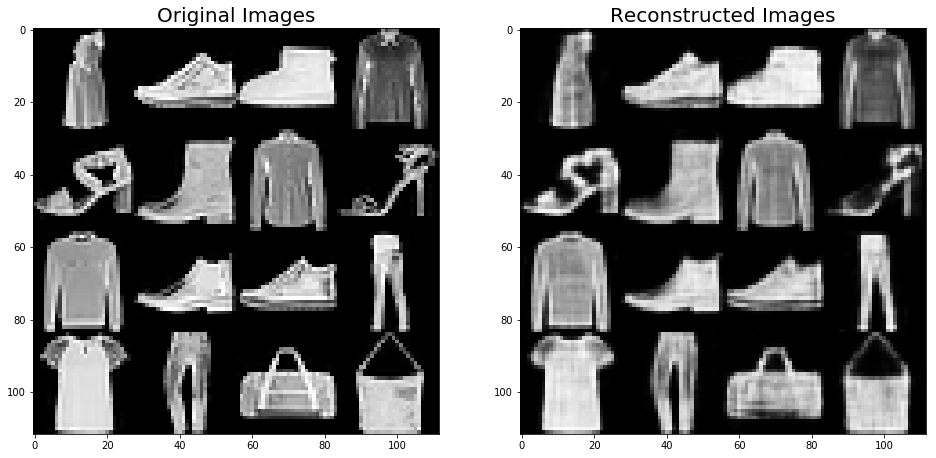

In [93]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n0 = 4
n = n0 * n0

# MNIST test set
batch_x, _ = mnist.test.next_batch(n)
g = sess.run(decoder_op, feed_dict={input_data: batch_x})

canvas_orig = batch_to_grid(batch_x, n0)
canvas_recon = batch_to_grid(g, n0)

plt.figure(figsize=(2*n0 * 2, n0 * 2))

plt.subplot(121)
plt.title("Original Images", fontsize=20)
plt.imshow(canvas_orig, origin="upper", cmap="gray")

plt.subplot(122)
plt.title("Reconstructed Images", fontsize=20)
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()